In [1]:
%%capture
!pip install transformers==4.35.2
!pip install datasets==2.15.0
!pip install soundfile==0.12.1
!pip install speechbrain==0.5.16

In [5]:
from transformers import pipeline

# example of pipelien text-to-speech
pipe=pipeline("text-to-speech", model="suno/bark-small", device='cuda')
text="[clears throat] Hello my name is"
output=pipe(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [6]:
from IPython.display import Audio

Audio(output["audio"], rate=output["sampling_rate"])

In [7]:
!pip install kaggle_secrets

ERROR: Could not find a version that satisfies the requirement kaggle_secrets (from versions: none)
ERROR: No matching distribution found for kaggle_secrets


In [8]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tuning speech-t5"
os.environ["WANDB_NOTES"] = "Fine tune model distilbert base uncased"
os.environ["WANDB_NAME"] = "ft-speech-t5-on-voxpopuli"

ModuleNotFoundError: No module named 'kaggle_secrets'

In [9]:
from datasets import load_dataset, Audio

dataset=load_dataset("facebook/voxpopuli","nl", split="train")
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 20968
})

SpeechT5 expects audio data to have a sampling rate of 16 kHz, so make sure the examples in the dataset meet this requirement.

In [10]:
dataset=dataset.cast_column("audio", Audio(sampling_rate=16000))

# Preprocess the data
Let's begin by defining the model checkpoint to use and loading the appropriate processor:

In [11]:
from transformers import SpeechT5Processor

checkpoint="microsoft/speecht5_tts"
processor=SpeechT5Processor.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [12]:
def extract_all_chars(batch):
    all_text=" ".join(batch["normalized_text"])
    vocab=list(set(all_text))
    return {"vocab": [vocab], "all_text":[all_text]}

vocabs=dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)


tokenizer=processor.tokenizer

dataset_vocab=set(vocabs["vocab"][0])
tokenizer_vocab={k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

In [13]:
print(dataset_vocab-tokenizer_vocab)


replacements=[
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"]=inputs["normalized_text"].replace(src, dst)
    return inputs

dataset=dataset.map(cleanup_text)

{'ï', 'í', 'à', 'ç', 'è', 'ü', 'ë', ' ', 'ö'}


Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

Now that we have deal with special characters in the text, it's time to shift focus to the audio data.

# Checking Speakers

The VoxPopuli dataset includes speech from multiple speakers, but how many speakers are represented in the datasets? To determine this, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset. With a total of 20968 examples in the dataset, this information will give us a better understanding of the distribution of speakers and examples in the data.

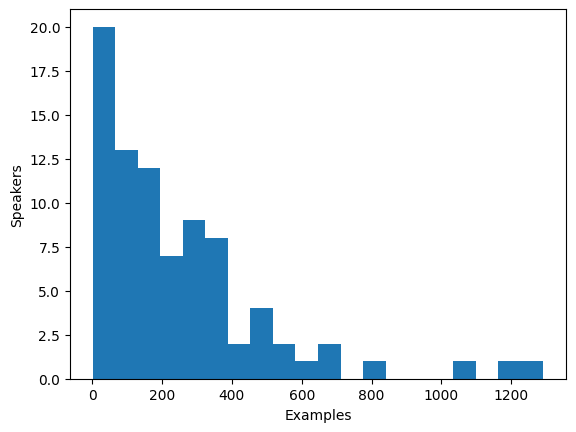

In [14]:
from collections import defaultdict
import matplotlib.pyplot as plt

speaker_counts=defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id]+=1

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

# Cleaning Data

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while arounf ten speakers have more than 500 examples. To improve training effficiency and balance the dataset, we can limit the data to speakers with between 100 and 400 examples.

Note that some speakers with few examples may actually have more audio available if the examples are long. However, determining the total amount of audio for each speaker requires scanning through the entire dataset, which is a time-consuming process that involves loading and decoding each audio file. As such, we have chosen to skip this step here.

In [15]:
def select_speaker(speaker_id):
    return 100<=speaker_counts[speaker_id]<=400

dataset=dataset.filter(select_speaker, input_columns=["speaker_id"])

# Let's check how many speakers remain
print(len(set(dataset["speaker_id"])))

# Let's see how many examples are left
print(len(dataset))

Filter:   0%|          | 0/20968 [00:00<?, ? examples/s]

42
9973


# Speaker embeddings

To enable the TTS model to differentiable between multiple speakers, we will need to create a speaker emebeddings for each example. The speaker embedding it an additional input into the model that captures a particular speaker's voice characteristics. To generate these speakers embeddings, use the pre-trained spkrec-xvect-voxceleb model from SpeechBrain. Create a function **create_speaker_emebdding()** that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding. It's important to note that the speechbrain/spkrec-xvect-voxceleb model was trained on English speech from the VoxCeleb dataset, whereas the training examples in here are in Dutch. While we believe that this model will still generate reasonable speaker embeddings for our Dutch dataset, this assumption may not hold true in all cases.

For optimal results, we recommend training an X-vector model on the target speech first. This will ensure that the model is better able to capture the unique voice characteristics present in the Dutch language.

In [16]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name="speechbrain/spkrec-xvect-voxceleb"

device="cuda"
speaker_model=EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings=speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings=torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings=speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings


def prepare_dataset(example):
    audio=example["audio"]

    example=processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off thje batch dimension
    example["labels"]=example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"]=create_speaker_embedding(audio["array"])

    return example

hyperparams.yaml: 0.00B [00:00, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt: 0.00B [00:00, ?B/s]

Verify the processing is correct by looking at a single example, the speaker embeddings should be a 512-element vector, and the labels should be a log-mel spectrogram with 80 mel bins.

['input_ids', 'labels', 'speaker_embeddings']
(512,)


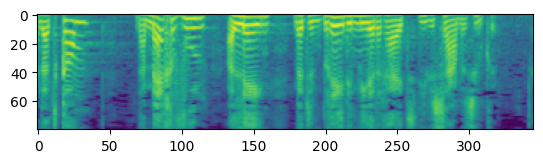

In [17]:
import matplotlib.pyplot as plt


processed_example=prepare_dataset(dataset[0])
print(list(processed_example.keys()))
print(processed_example["speaker_embeddings"].shape)

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [18]:
# applying the processing function to the entire dataset
dataset=dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/9973 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


In [19]:
def is_not_too_long(input_ids):
    input_length=len(input_ids)
    return input_length<200

dataset=dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

In [20]:
dataset=dataset.train_test_split(test_size=0.1)

In [21]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:

    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids=[{"input_ids":feature["input_ids"]} for feature in features]
        label_features=[{"input_values":feature["labels"]} for feature in features]
        speaker_features=[feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch=processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"]=batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1),-100)

        #not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor>1:
            target_lengths=torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths=target_lengths.new(
                [length-length%model.config.reduction_factor for length in target_lengths]
            )
            max_length=max(target_lengths)
            batch["labels"]=batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"]=torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [22]:
data_collator=TTSDataCollatorWithPadding(processor=processor)

# Train the model

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training.

In [23]:
from transformers import SpeechT5ForTextToSpeech

model=SpeechT5ForTextToSpeech.from_pretrained(checkpoint)
model.config.use_cache=False
print(model.config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

SpeechT5Config {
  "_name_or_path": "microsoft/speecht5_tts",
  "activation_dropout": 0.1,
  "apply_spec_augment": true,
  "architectures": [
    "SpeechT5ForTextToSpeech"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 12,
  "encoder_max_relative_position": 160,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.0,
  "guided_attention_loss_num_heads": 2,
  "guided_attention_loss_scale": 10.0,
  "guided_attention_loss_sigma": 

In [32]:
!pip install -U huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.33.0
    Uninstalling huggingface-hub-0.33.0:
      Successfully uninstalled huggingface-hub-0.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.


In [35]:
!pip install transformers

In [37]:
!pip install pip install peft==0.10.0


ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install


In [38]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args=Seq2SeqTrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=100,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=50,
    eval_steps=50,
    logging_steps=25,
    report_to="wandb", # or report_to="tensorboard"
    run_name=os.getenv("WANDB_NAME"),
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

trainer=Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()

RuntimeError: Failed to import transformers.trainer_seq2seq because of the following error (look up to see its traceback):
cannot import name 'Cache' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

In [26]:
trainer.evaluate()

NameError: name 'trainer' is not defined

In [27]:
processor.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(os.getenv("WANDB_NAME"))

AttributeError: 'NoneType' object has no attribute 'split'

# Inference

In [28]:
from transformers import pipeline()

pipe=pipeline("text-to-speech", model=os.getenv("WANDB_NAME"), device='cuda')

SyntaxError: invalid syntax (ipython-input-28-1563825445.py, line 1)

In [29]:
text="hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

example=dataset["test"][304]
speaker_emebeddings=torch.tensor(example["speaker_emebddings"]).unsqueeze(0)

forward_params={"speaker_embeddings": speaker_embeddings}
output=pipe(text, forward_params=forward_params)

KeyError: 'speaker_emebddings'

In [30]:
from IPython.display import Audio
Audio(output['audio'], rate=output['sampling_rate'])